In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

import warnings
warnings.filterwarnings('ignore')

### Data tidying

In [2]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
caratPriceDict = dict()
caratAmountDict = dict()

for index, row in df.iterrows():
    if row['carat'] not in caratPriceDict.keys():
        caratPriceDict[row['carat']] = 0
    if row['carat'] not in caratAmountDict.keys():
        caratAmountDict[row['carat']] = 0

    caratPriceDict[row['carat']] += row['price']
    caratAmountDict[row['carat']] += 1

caratPriceDict = {k: v/caratAmountDict[k] for k, v in caratPriceDict.items()}
caratPriceDict = dict(sorted(caratPriceDict.items()))

carat = list(caratPriceDict.keys())
price = list(caratPriceDict.values())

caratPrice = {"carat":carat, "price":price}
dfCaratPrice = pd.DataFrame(caratPrice)
dfCaratPrice.to_csv(r'output/caratPrice.csv', index=False)

Linear function:
 
5625 x + 192.5


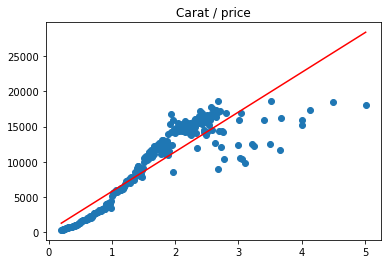

Polynomial function:
       4        3             2
514.7 x - 4797 x + 1.274e+04 x - 3957 x + 616.6


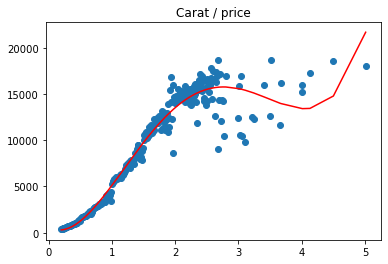

In [4]:
plt.scatter(carat, price)
z = np.polyfit(carat, price, 1)
p = np.poly1d(z)
print("Linear function:")
print(p)
trend_h = p(carat)
plt.plot(carat,trend_h, "r-")
plt.title("Carat / price")
plt.show()

plt.scatter(carat, price)
z = np.polyfit(carat, price, 4)
p = np.poly1d(z)
print("Polynomial function:")
print(p)
trend_h = p(carat)
plt.plot(carat,trend_h, "r-")
plt.title("Carat / price")
plt.show()

### Data analysis

In [5]:
df = pd.read_csv("output/caratPrice.csv")
df.head()

print(df.describe())

            carat         price
count  273.000000    273.000000
mean     1.608791   9242.669570
std      0.894875   5606.869496
min      0.200000    365.166667
25%      0.880000   3342.322581
50%      1.560000  10424.000000
75%      2.240000  14481.333333
max      5.010000  18701.000000


### Model 1 - Linear regression

Prior predictive check

In [108]:
model_1_ppc = CmdStanModel(stan_file='model_1_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_1_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_1_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_1_ppc.exe


In [107]:
model_1_sim = model_1_ppc.sample(iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


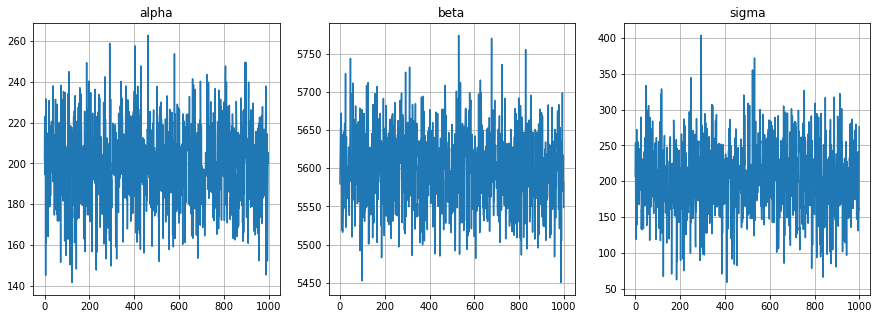

,mean,sd,hdi_3%,hdi_97%
alpha,199.69,19.83,160.55,234.73
beta,5599.32,48.98,5504.97,5683.97
sigma,203.38,49.58,116.67,301.30


In [105]:
alpha_sim = model_1_sim.stan_variable('alpha')
beta_sim = model_1_sim.stan_variable('beta')
sigma_sim = model_1_sim.stan_variable('sigma')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_sim,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

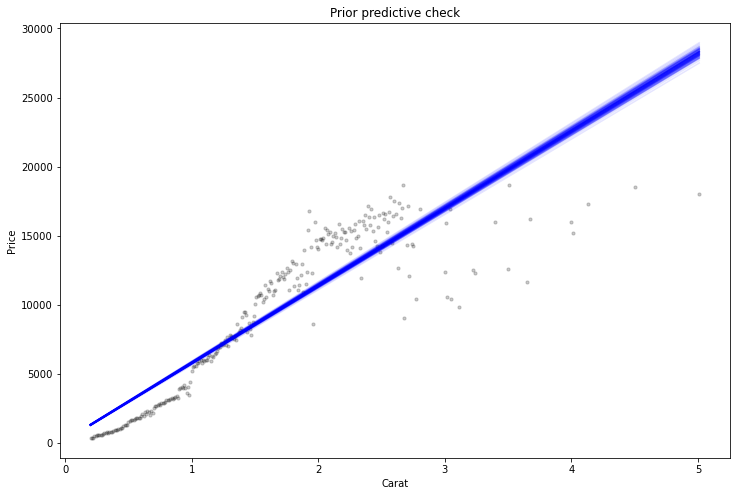

In [58]:
plt.figure(figsize=[12, 8])
for i in range(100):
    plt.plot(df.carat, alpha_sim[i] + beta_sim[i] * df.carat, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Prior predictive check")
plt.show()

Posterior analysis

In [97]:
model_lr = CmdStanModel(stan_file='model_lr.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.exe


In [98]:
result_lr = model_lr.sample(data=dict(N=len(df), x=df.carat.values, y=df.price.values))
#print(result_lr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -6968.64       0.962460    0.684839          2.0           3.0   
1    -6968.02       1.000000    0.684839          3.0           7.0   
2    -6966.56       0.841698    0.684839          2.0           7.0   
3    -6966.80       0.905624    0.684839          1.0           3.0   
4    -6966.72       0.920640    0.684839          3.0           7.0   
...       ...            ...         ...          ...           ...   
3995 -6967.07       0.928938    0.633489          2.0           3.0   
3996 -6967.34       0.939257    0.633489          3.0           7.0   
3997 -6971.96       0.686613    0.633489          2.0           7.0   
3998 -6966.55       1.000000    0.633489          3.0           7.0   
3999 -6968.14       0.873015    0.633489          2.0           3.0   

      divergent__  energy__    alpha     beta    sigma  ...  log_lik[264]  \
0             0.0   6972.65  232.026  5630.18  678.437  ...      -20.

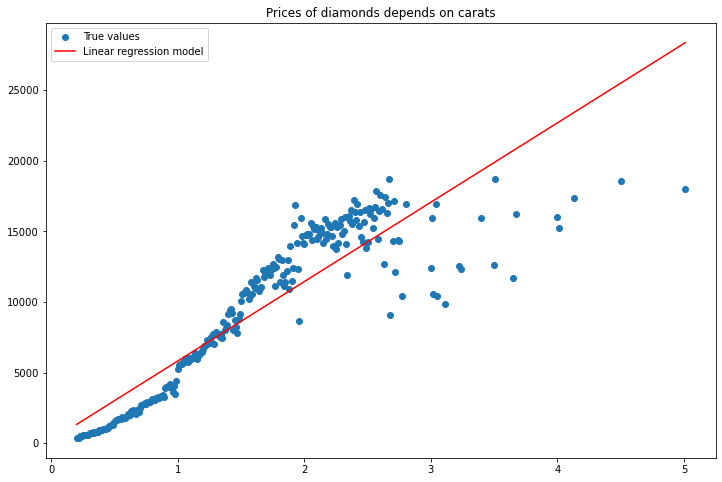

In [99]:
df_alpha = pd.DataFrame(result_lr.stan_variables()["alpha"])
df_beta = pd.DataFrame(result_lr.stan_variables()["beta"])
df_sigma = pd.DataFrame(result_lr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta = df_beta.mean().to_numpy()
sigma= df_sigma.mean().to_numpy()

x = df.carat.values
y = alpha + beta*x

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Linear regression model"])
plt.show()

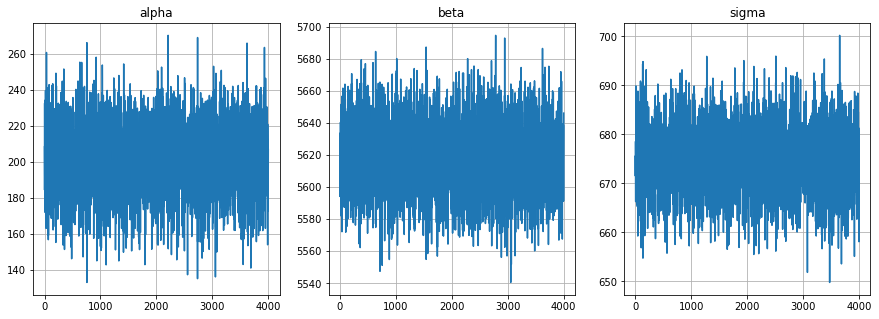

,mean,sd,hdi_3%,hdi_97%
alpha,200.75,19.00,167.52,238.77
beta,5617.85,21.43,5576.97,5657.76
sigma,674.57,6.57,662.83,687.10


In [103]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(result_lr,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

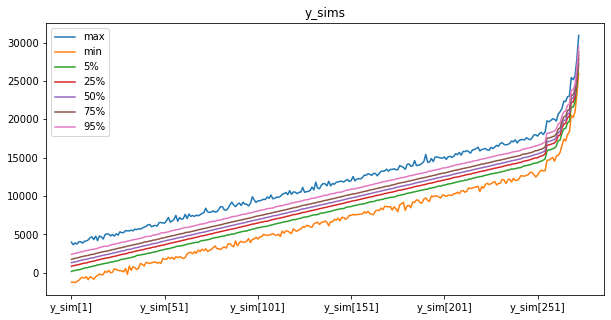

In [104]:
data = result_lr.draws_pd()
y_sims = data[data.columns[10:283]]

quans = pd.DataFrame({'max': y_sims.max(), 'min': y_sims.min(), '5%': y_sims.quantile(0.05), '25%': y_sims.quantile(0.25), '50%': y_sims.quantile(0.5), '75%': y_sims.quantile(0.75), '95%': y_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("y_sims")
plt.show()

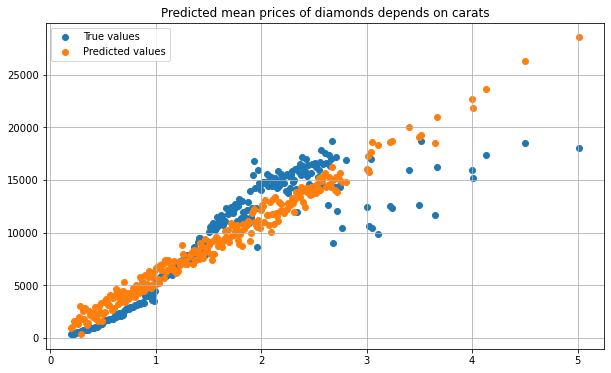

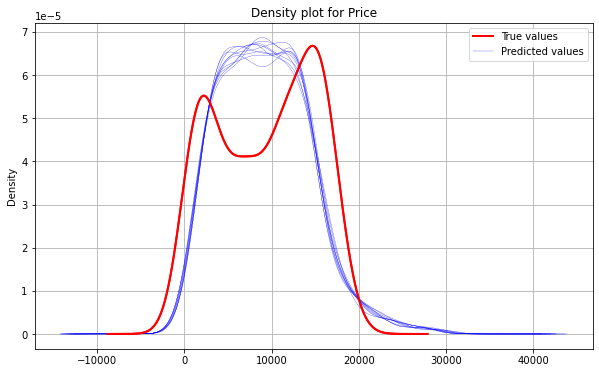

In [101]:
y_sim = result_lr.stan_variable('y_sim')
plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 2 - Polynomial regression

Prior predictive check

In [126]:
model_2_ppc = CmdStanModel(stan_file='model_2_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.exe


In [127]:
model_2_sim = model_2_ppc.sample(iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


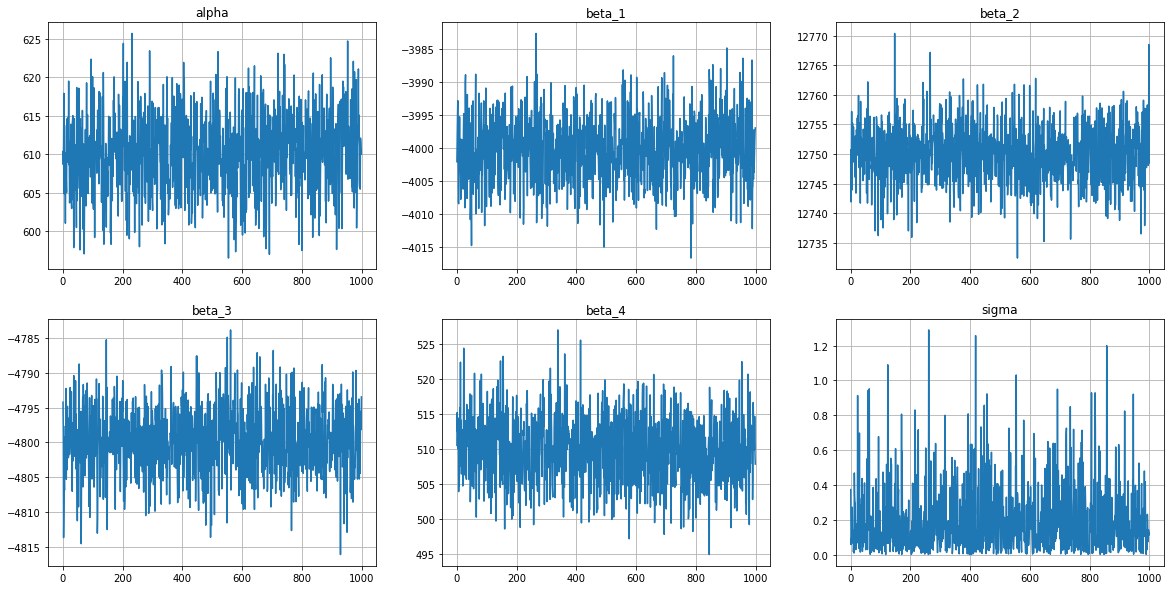

,mean,sd,hdi_3%,hdi_97%
alpha,610.17,5.13,600.27,619.52
beta_1,-4000.18,4.99,-4009.10,-3990.65
beta_2,12749.96,4.95,12741.20,12759.30
beta_3,-4799.83,4.92,-4809.69,-4791.46
beta_4,509.88,4.82,501.24,518.88
sigma,0.20,0.20,0.00,0.57


In [128]:
alpha_sim = model_2_sim.stan_variable('alpha')
beta_1_sim = model_2_sim.stan_variable('beta_1')
beta_2_sim = model_2_sim.stan_variable('beta_2')
beta_3_sim = model_2_sim.stan_variable('beta_3')
beta_4_sim = model_2_sim.stan_variable('beta_4')
sigma_sim = model_2_sim.stan_variable('sigma')

fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_1_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].plot(beta_2_sim)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].plot(beta_3_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].plot(beta_4_sim)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].plot(sigma_sim)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

az.summary(model_2_sim,var_names=['alpha','beta_1','beta_2','beta_3','beta_4','sigma'],round_to=2,kind='stats')

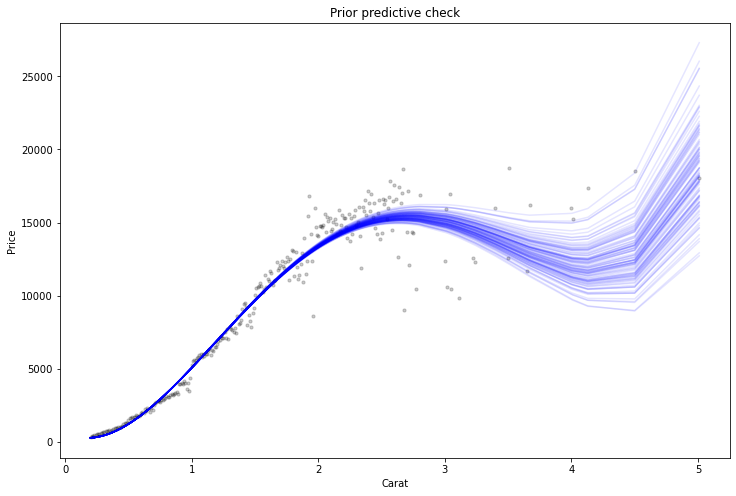

In [129]:
plt.figure(figsize=[12, 8])
for i in range(100):
    plt.plot(df.carat, alpha_sim[i] + beta_1_sim[i] * df.carat + beta_2_sim[i] * df.carat**2 + beta_3_sim[i] * df.carat**3 + beta_4_sim[i] * df.carat**4, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Prior predictive check")
plt.show()

Posterior analysis

In [130]:
model_pr = CmdStanModel(stan_file='model_pr.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.exe


In [131]:
result_pr = model_pr.sample(data=dict(N=len(df), x=df.carat.values, y=df.price.values))
#print(result_pr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


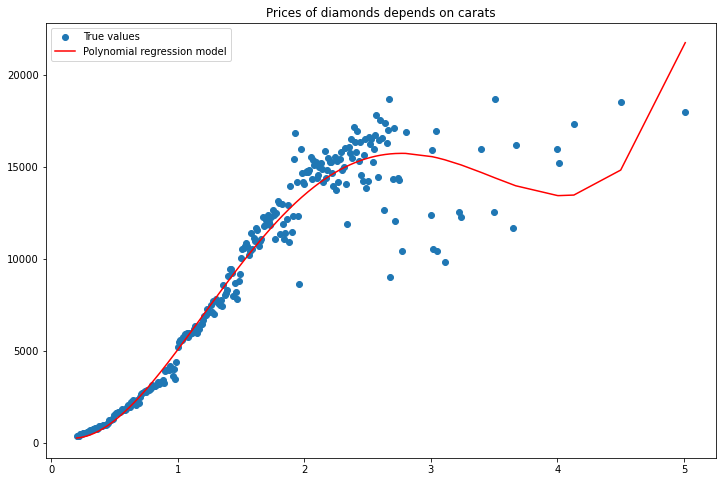

In [133]:
df_alpha = pd.DataFrame(result_pr.stan_variables()["alpha"])
df_beta_1 = pd.DataFrame(result_pr.stan_variables()["beta_1"])
df_beta_2 = pd.DataFrame(result_pr.stan_variables()["beta_2"])
df_beta_3 = pd.DataFrame(result_pr.stan_variables()["beta_3"])
df_beta_4 = pd.DataFrame(result_pr.stan_variables()["beta_4"])
df_sigma = pd.DataFrame(result_pr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta_1 = df_beta_1.mean().to_numpy()
beta_2 = df_beta_2.mean().to_numpy()
beta_3 = df_beta_3.mean().to_numpy()
beta_4 = df_beta_4.mean().to_numpy()

sigma= df_sigma.mean().to_numpy()

x = df.carat.values
y = alpha + beta_1*x + beta_2*(x**2) + beta_3*(x**3) + beta_4*(x**4)

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Polynomial regression model"])
plt.show()

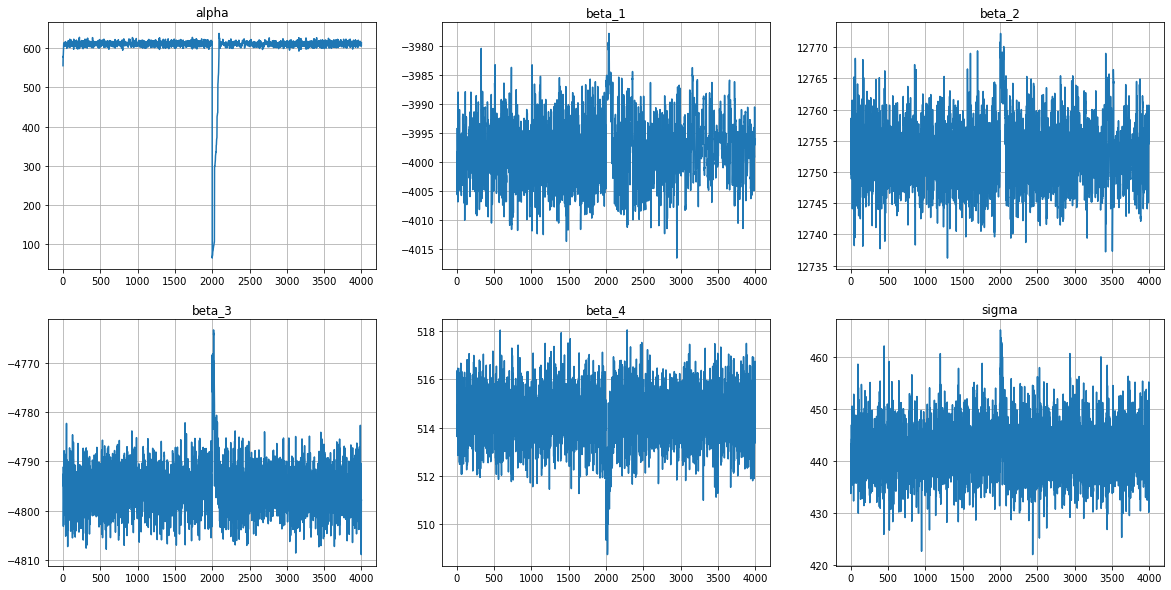

In [134]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].plot(df_alpha)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(df_beta_1)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].plot(df_beta_2)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].plot(df_beta_3)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].plot(df_beta_4)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].plot(df_sigma)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

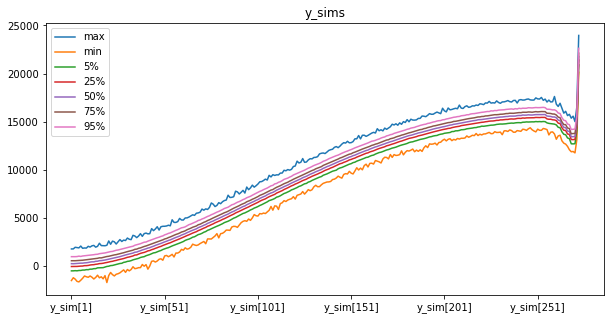

In [135]:
data = result_pr.draws_pd()
y_sims = data[data.columns[13:286]]

quans = pd.DataFrame({'max': y_sims.max(), 'min': y_sims.min(), '5%': y_sims.quantile(0.05), '25%': y_sims.quantile(0.25), '50%': y_sims.quantile(0.5), '75%': y_sims.quantile(0.75), '95%': y_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("y_sims")
plt.show()

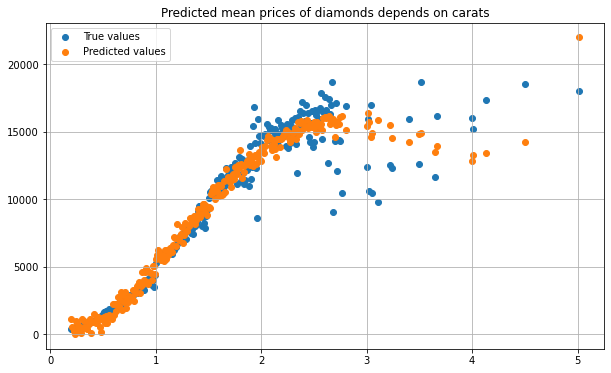

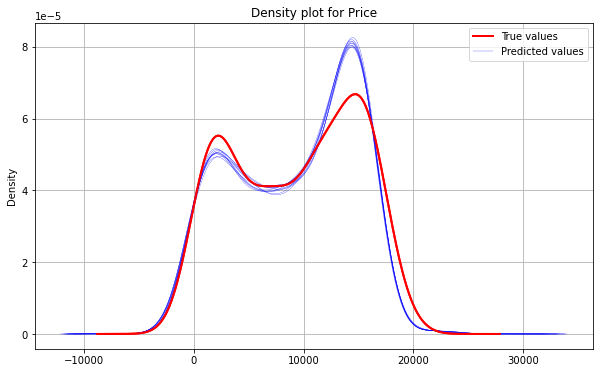

In [136]:
y_sim = result_pr.stan_variable('y_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 3 - Gaussian process

In [59]:
model_gp_opt = CmdStanModel(stan_file='model_gp_opt.stan')
data = dict(N = len(df), x = df.carat.values, y = df.price.values)
result_gp_opt = model_gp_opt.optimize(data=data, algorithm='Newton')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
model_gp = CmdStanModel(stan_file='model_gp.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmptfi0zeji/tmpwoi4ri06.hpp C:/Users/Marcin/AppData/Local/Temp/tmptfi0zeji/tmpwoi4ri06.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmptfi0zeji/tmpwoi4ri06.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmptfi0zeji/tmpwoi4ri06.stan', line 4, column 4: Declaration
    of

In [32]:
"""
result = result_gp_opt.optimized_params_pd

alpha = float(result['alpha'])
rho = float(result['rho'])
sigma = float(result['sigma'])

print(alpha)
print(rho)
print(sigma)
"""
alpha = 130
rho = 1
sigma = 100


In [33]:
idx = range(1, len(df.price.values)+1)
data = dict(N = len(df), x = df.carat.values, y = df.price.values, idx = idx, rho=rho, alpha=alpha, sigma=sigma)
result_gp = model_gp.sample(data=data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


      y_sim[1]  y_sim[2]  y_sim[3]  y_sim[4]  y_sim[5]  y_sim[6]  y_sim[7]  \
0      270.981   439.367   235.569   526.467   467.220   661.880   504.491   
1      482.125   559.926   432.813   428.972   610.370   707.929   665.229   
2      348.788   405.082   470.427   421.660   259.584   486.614   548.308   
3      326.015   476.062   451.042   520.837   543.066   477.857   534.295   
4      410.418   547.027   396.582   438.965   407.317   398.801   485.120   
...        ...       ...       ...       ...       ...       ...       ...   
3995   489.497   445.345   439.334   329.468   476.903   473.353   407.601   
3996   287.470   428.476   528.205   448.549   476.953   541.409   553.714   
3997   507.862   456.902   405.333   601.467   441.441   594.987   595.270   
3998   405.990   539.699   499.465   521.642   552.876   539.149   718.877   
3999   386.424   404.014   615.615   499.877   278.310   476.660   525.812   

      y_sim[8]  y_sim[9]  y_sim[10]  ...  y_sim[264]  y_sim[265

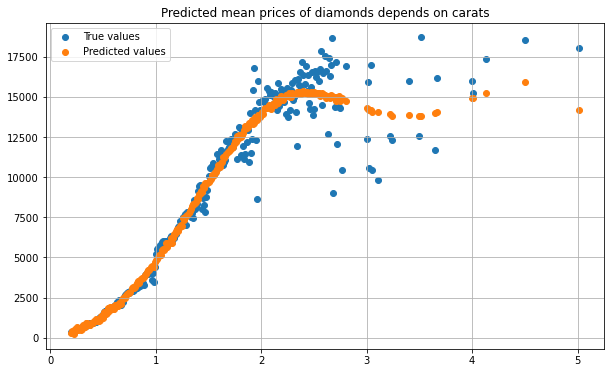

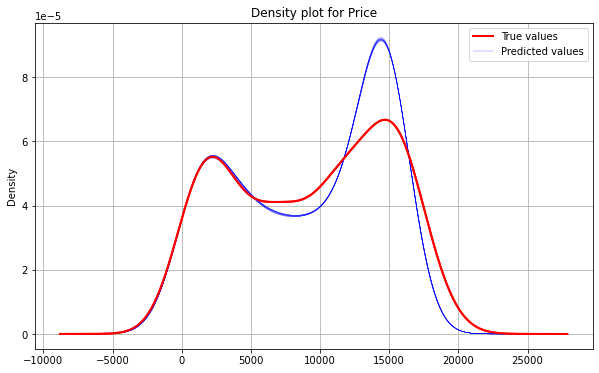

In [38]:
data = result_gp.draws_pd()
y_sims = data[data.columns[826:]]
y_sim = result_gp.stan_variable('y_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[0])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Comparison of models



           rank           loo        p_loo         d_loo    weight  \
model_lr_     0  -2675.244976     8.850748      0.000000  0.234203   
model_pr_     1  -2928.176295    80.855237    252.931319  0.543948   
model_gp_     2 -21687.055269  1032.698594  19011.810293  0.221849   

                    se          dse  warning loo_scale  
model_lr_    55.486670     0.000000    False       log  
model_pr_   169.125273   138.982726     True       log  
model_gp_  3367.240473  3339.967275     True       log  


<AxesSubplot:xlabel='Log'>

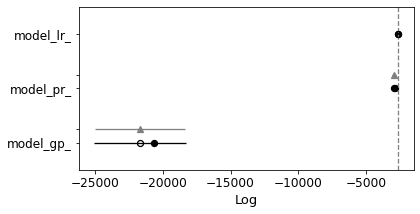

In [73]:
data = dict(model_lr_ = result_lr, model_pr_ = result_pr, model_gp_ = result_gp)
comp_loo = az.compare(data, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)



           rank          waic       p_waic        d_waic    weight  \
model_lr_     0  -2675.239066     8.844838      0.000000  0.234226   
model_pr_     1  -2938.683522    91.362465    263.444457  0.543916   
model_gp_     2 -22503.695456  1849.338781  19828.456390  0.221858   

                    se          dse  warning waic_scale  
model_lr_    55.487011     0.000000     True        log  
model_pr_   171.843666   140.395271     True        log  
model_gp_  3567.584747  3537.551046     True        log  


<AxesSubplot:xlabel='Log'>

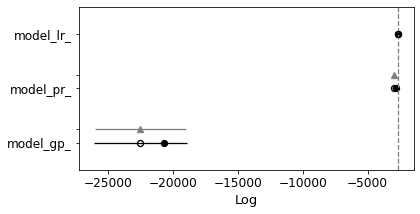

In [74]:
comp_waic = az.compare(data, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)